# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [5]:
!pip install torch

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import init
import sklearn
import torch.optim as optim
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from itertools import product
from sklearn.preprocessing import StandardScaler

## Загрузка данных

In [2]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [3]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


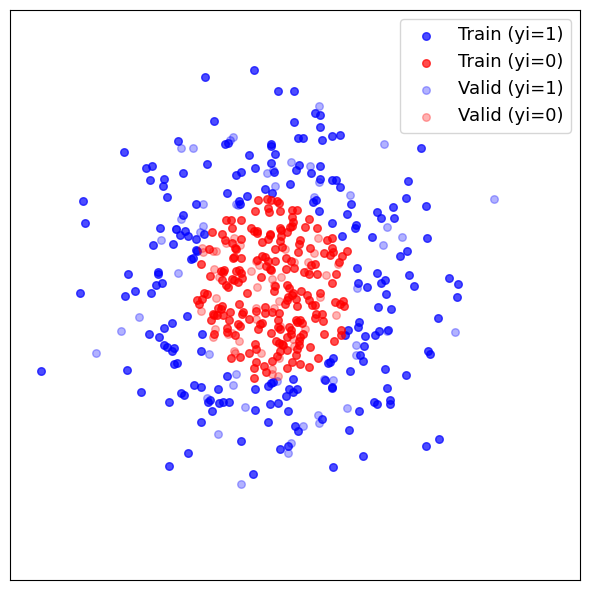

In [4]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, initializer=None):
        ### YOUR CODE HERE
        super().__init__()
        self.layer1 = nn.Linear(2, 4)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
        self.loss_history = []

        if initializer:
            self.apply(self.initialize_weight(initializer))


    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

    def initialize_weight(self, initializer):
        def initialize_fun(model):
            if isinstance(model, nn.Linear):
                initializer.initialize(model.weight)
                if model.bias is not None:
                    init.zeros_(model.bias) 

        return initialize_fun




##  Функция обучения сети

Необходимо сохранять историю лоссов для последующего сравнения и визуализации.
Также нужно реализовать early stopping. Критерий остановки подбирите на ваше усмотрение.

In [6]:
def train_model(model, loss, opt,
          X_train, y_train,
          n_epochs=300, batch_size=16):

    loss_fn = loss
    optim = opt['function']
    optimizer = optim(model.parameters(), **opt['params'])
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    eps = 10**(-8)
    for epoch in range(n_epochs):
        loss_sum = 0
        count = 0
        for start in batch_start:
            count += 1
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss_sum += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.loss_history.append(loss_sum / count)
        if epoch > 2 and abs(model.loss_history[-1] - model.loss_history[-2]) < eps:
            break
    return

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [7]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float().reshape(-1, 1)
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float().reshape(-1, 1)

model_list = []
accuracies = []


optims = {'SGD': {'function': optim.SGD, 
                    'params': {'lr': 0.01,
                               'momentum': 0.8}
                    }, 
          'Adam': {'function': optim.Adam, 
                    'params': {'lr': 0.01}
                    },
          'RMSProp': {'function': optim.RMSprop, 
                    'params': {'lr': 0.01,
                               'alpha': 0.9}
                    }, 
}

for opt_name, opt in optims.items():
    model = NeuralNetwork()
    model_list.append(model)
    train_model(model, loss=nn.BCELoss(), opt=opt, X_train=X_train_torch, y_train=y_train_torch)
    model.eval()
    y_pred = model(X_valid_torch)
    acc = (y_pred.round() == y_valid_torch).float().mean()
    acc = float(acc)
    print(f"Accuracy {opt_name}: %.2f " % acc)
    accuracies.append(acc)

Accuracy SGD: 0.81 
Accuracy Adam: 0.98 
Accuracy RMSProp: 0.95 


### А теперь посмотрим на графики лоссов

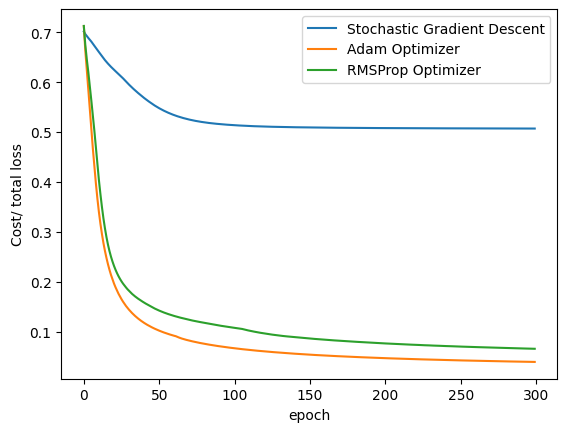

In [8]:
loss_SGD = model_list[0].loss_history
loss_Adam = model_list[1].loss_history
loss_rmsprop = model_list[2].loss_history
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните эти две модели на предыдущей задаче.

In [9]:
class RandomNetwork:
    def __init__(self, gain=1.0):
        self.gain = gain
        
    def initialize(self, tensor):
        init.uniform_(tensor)

class XavierNetwork:
    def __init__(self, gain=1.0):
        self.gain = gain
        
    def initialize(self, tensor):
        init.xavier_uniform_(tensor, gain=self.gain)



In [10]:
list_mode = [RandomNetwork(), XavierNetwork()]
for opt_name, opt in optims.items():
    for i in range(2):
        model = NeuralNetwork(list_mode[i])
        model_list.append(model)
        train_model(model, loss=nn.BCELoss(), opt=opt, X_train=X_train_torch, y_train=y_train_torch)
        model.eval()
        y_pred = model(X_valid_torch)
        acc = (y_pred.round() == y_valid_torch).float().mean()
        acc = float(acc)
        print(f"Accuracy {opt_name} + {type(list_mode[i]).__name__}: %.2f " % acc)
        accuracies.append(acc)


Accuracy SGD + RandomNetwork: 0.94 
Accuracy SGD + XavierNetwork: 0.95 
Accuracy Adam + RandomNetwork: 0.98 
Accuracy Adam + XavierNetwork: 0.75 
Accuracy RMSProp + RandomNetwork: 0.96 
Accuracy RMSProp + XavierNetwork: 0.97 


In [11]:
#со стандартной инициализацией весов
for opt_name, opt in optims.items():
    model = NeuralNetwork()
    model_list.append(model)
    train_model(model, loss=nn.BCELoss(), opt=opt, X_train=X_train_torch, y_train=y_train_torch)
    model.eval()
    y_pred = model(X_valid_torch)
    acc = (y_pred.round() == y_valid_torch).float().mean()
    acc = float(acc)
    print(f"Accuracy {opt_name}: %.2f " % acc)
    accuracies.append(acc)

Accuracy SGD: 0.68 
Accuracy Adam: 0.97 
Accuracy RMSProp: 0.98 


Для различных оптимизаторов (SGD, Adam, RMSProp) кастомная инициализация весов показал более стабильные и высокие результаты. При многократных запусках с использованием встроенной инициализации наблюдался широкий разброс значений точности.
Следовательно, правильно подобранная инициализация позволяет увеличить устойчивость модели и делает результаты более предсказуемым.

## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

**Найдите лучшие параметры через KFold**

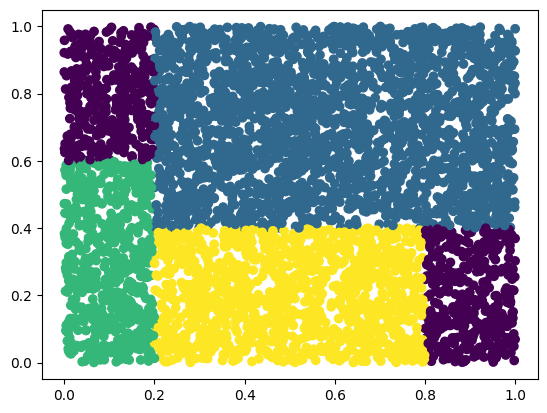

In [12]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

X = torch.as_tensor(points, dtype=torch.float32)
y = torch.as_tensor(target, dtype=torch.long)

X_train, y_train = X[:800], y[:800]
X_valid, y_valid = X[800:900], y[800:900]
X_test,  y_test  = X[900:],  y[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [13]:
class AdvancedModel(nn.Module):
    def __init__(self,initializer, input_dim=2, hidden_dim=6, output_dim=4, batch_norm=False):
        super(AdvancedModel, self).__init__()
        self.batch_norm = batch_norm
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        if batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.loss_history = [] #тут хранится история loss

        if initializer:
            self.apply(self.initialize_weight(initializer))


    def forward(self, x):
        x = self.layer1(x)
        if self.batch_norm:
            x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.layer2(x)
        return x

    def initialize_weight(self, initializer):
        def initialize_fun(model):
            if isinstance(model, nn.Linear):
                initializer.initialize(model.weight)
                if model.bias is not None:
                    init.zeros_(model.bias) 

        return initialize_fun


In [15]:
model = AdvancedModel(initializer=XavierNetwork()) 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
def train_model(model, loss, optimizer,
                X_train, y_train, X_val, y_val,
                n_epochs=300, batch_size=16):
    
    loss_fn = loss
    batch_start = torch.arange(0, len(X_train), batch_size)

    model.train()
    eps = 10**(-8)
    for epoch in range(n_epochs):
        loss_sum = 0
        count = 0
        for start in batch_start:
            count += 1
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss_sum += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.loss_history.append(loss_sum / count)
        if epoch > 2 and abs(model.loss_history[-1] - model.loss_history[-2]) < eps:
            break

    # evaluation
    model.eval()
    y_pred = model(X_val)
    y_pred = torch.argmax(y_pred, dim=1)
    acc = (y_pred == y_val).float().mean()
    acc = float(acc)
    return acc



In [17]:
list_mode = [RandomNetwork(), XavierNetwork()]

optims = {'SGD': {'function': optim.SGD, 
                    'params': {'lr': np.logspace(-3, -1, 3).tolist(),
                               'momentum': torch.linspace(0.5, 0.99, 3).tolist()}
                    }, 
          'Adam': {'function': optim.Adam, 
                    'params': {'lr': np.logspace(-3, -1, 4).tolist()}
                    },
          'RMSProp': {'function': optim.RMSprop, 
                    'params': {'lr': np.logspace(-3, -1, 3).tolist(),
                               'alpha': torch.linspace(0.8, 0.99, 3).tolist()}
                    }, 
}

param_grid = {
    'initializer': list_mode,
    'hidden_dim': [8, 16],
    'optimizer': list(optims.keys()),
    'epochs': [30],
}


In [18]:
# run 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_acc = 0
best_config = None
#Тут будет не очень красивый код, с перебором разных параметров( 
param_names = list(param_grid.keys())
param_values = list(param_grid.values())
loss_fn = nn.CrossEntropyLoss()
#перебор  оптимизатора, кол-ва эпох, размер скрытого слоя и параметром инициализации весов
for conf in product(*param_values):
    
    #тут словари с названием оптимизатора, кол-ва эпох, размер скрытого слоя и параметром инициализации весов
    config = dict(zip(param_names, conf)) 

    initializer = config['initializer']
    hidden_dim = int(config['hidden_dim'])
    epochs = int(config['epochs'])
    
    #берем функцию оптимизатора
    opt = optims[config['optimizer']]['function'] 
    
    #Достаем параметр и сетку значений
    opt_param_names = list(optims[config['optimizer']]['params'].keys())
    opt_param_values = list(optims[config['optimizer']]['params'].values())
    
    #так как внутри оптимайзера есть перебираемые параметры(lr, momentum, alpha), то дальше мы их и перебираем
    for param_comb in product(*opt_param_values):
        
        #тут хранятся данные о парметрах оптимизатора в данной итерации 
        opt_param_dict = dict(zip(opt_param_names, param_comb))
        
        accuracies = []
        
        for train, test in kfold.split(X, y):
            model = AdvancedModel(initializer=initializer, hidden_dim=hidden_dim)  # или RandomNetwork()
            loss_fn = nn.CrossEntropyLoss()
            optimizer = opt(model.parameters(), **opt_param_dict)
            acc = train_model(model,loss_fn, optimizer, X[train], y[train], X[test], y[test], n_epochs=epochs)
            accuracies.append(acc)

        mean = np.mean(accuracies)
        if mean > best_acc:
                best_acc = mean
                best_config = {
                    'initializer': initializer,
                    'hidden_dim': hidden_dim,
                    'optimizer_name': config['optimizer'],
                    'optimizer_params': opt_param_dict,
                    'epochs': epochs
                }
        
print("\n🔍 Best Configuration:")
print(f"Accuracy: {best_acc:.4f}")
print(f"Config: {best_config}")


🔍 Best Configuration:
Accuracy: 0.9780
Config: {'initializer': <__main__.XavierNetwork object at 0x318064a00>, 'hidden_dim': 16, 'optimizer_name': 'RMSProp', 'optimizer_params': {'lr': 0.01, 'alpha': 0.9900000095367432}, 'epochs': 30}


In [19]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
accuracies = []
for train, test in kfold.split(X, y):
    model = AdvancedModel(initializer=XavierNetwork(), hidden_dim=8) 
    loss_fn = nn.CrossEntropyLoss()
    opt = optims[best_config['optimizer_name']]['function']
    optimizer = opt(model.parameters(), **best_config['optimizer_params'])
    acc = train_model(model,loss_fn, optimizer, X[train], y[train], X[test], y[test], n_epochs=30)
    print("Accuracy: %.2f" % acc)
    accuracies.append(acc)

# evaluate the model
mean = np.mean(accuracies)
std = np.std(accuracies)
print("OVeral for hidden-dropout: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))

Accuracy: 0.95
Accuracy: 0.98
Accuracy: 0.96
Accuracy: 0.95
Accuracy: 0.97
Accuracy: 0.95
Accuracy: 0.98
Accuracy: 0.99
Accuracy: 0.98
Accuracy: 0.97
OVeral for hidden-dropout: 96.76% (+/- 1.30%)


С помощью K-fold были подобраны оптимальные параметры модели и оптимизатора.
'hidden_dim': 16, 'optimizer_name': 'RMSProp', 
'optimizer_params': {'lr': 0.01, 'alpha': 0.800000011920929}, 'epochs': 30}
Дополнительно с помощью 10-fold проверена итоговая модель с подобранными параметрами,которые подвердили высокое качество.


## (Почти) Боевая задача

Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [23]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.target.unique()

array([0, 1, 2])

In [24]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [60]:
X_df = df.drop('target', axis=1)
y_df = df['target']

X_train, X_test, y_train, y_test = train_test_split(X_df.values, y_df.values, test_size=0.50, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)   

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


In [61]:
optims = {'SGD': {'function': optim.SGD, # use SGD
                    'params': {'lr': 0.01,
                               'momentum': 0.8}
                    }, 
          'Adam': {'function': optim.Adam, # use Adam
                    'params': {'lr': 0.01}
                    },
          'RMSProp': {'function': optim.RMSprop, # use RMSProp
                    'params': {'lr': 0.01,
                               'alpha': 0.99}
                    }, 
}

In [62]:
list_mode = [RandomNetwork(), XavierNetwork()]
list_acc = []
list_model = []
list_valid = []
for opt_name,_ in optims.items():
    for i in range(2):
        model = AdvancedModel(initializer=list_mode[i], input_dim=13, hidden_dim=4, output_dim=3, batch_norm=False)
        model_list.append(model)
        loss_fn = nn.CrossEntropyLoss()
        opt = optims[opt_name]['function']
        optimizer = opt(model.parameters(), **optims[opt_name]['params'])
        list_model.append(model)
        acc = train_model(model,loss_fn, optimizer, X_train, y_train, X_test, y_test, batch_size=8,  n_epochs=300)
        model.eval()
        y_pred = model(X_val)
        y_pred = torch.argmax(y_pred, dim=1)
        acc1 = (y_pred == y_val).float().mean()
        acc1 = float(acc)
        list_acc.append(acc)
        print(f"Test accuracy {opt_name} + {type(list_mode[i]).__name__}: %.2f " % acc)
        print(f"Valid accuracy {opt_name} + {type(list_mode[i]).__name__}: %.2f " % acc1)

Test accuracy SGD + RandomNetwork: 0.95 
Valid accuracy SGD + RandomNetwork: 0.95 
Test accuracy SGD + XavierNetwork: 0.95 
Valid accuracy SGD + XavierNetwork: 0.95 
Test accuracy Adam + RandomNetwork: 0.98 
Valid accuracy Adam + RandomNetwork: 0.98 
Test accuracy Adam + XavierNetwork: 0.98 
Valid accuracy Adam + XavierNetwork: 0.98 
Test accuracy RMSProp + RandomNetwork: 1.00 
Valid accuracy RMSProp + RandomNetwork: 1.00 
Test accuracy RMSProp + XavierNetwork: 0.98 
Valid accuracy RMSProp + XavierNetwork: 0.98 


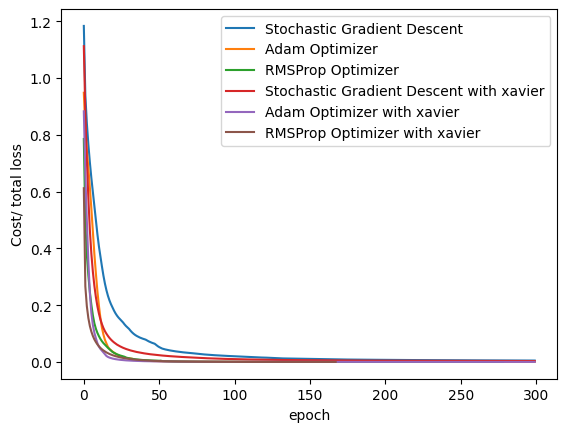

In [63]:
loss_SGD = list_model[0].loss_history
loss_Adam = list_model[2].loss_history
loss_rmsprop = list_model[4].loss_history
loss_SGD_xavier = list_model[1].loss_history
loss_Adam_xavier = list_model[3].loss_history
loss_rmsprop_xavier = list_model[5].loss_history
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.plot(loss_SGD_xavier, label = "Stochastic Gradient Descent with xavier")
plt.plot(loss_Adam_xavier, label = "Adam Optimizer with xavier")
plt.plot(loss_rmsprop_xavier, label = 'RMSProp Optimizer with xavier')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

Данный датасет отличается от предыдущих масштабом признаков. Поэтому перед обучением модели была необходима нормализация данных.
Качество модели оказалось стабильным и близким к 1, однако переобучения не наблюдается, так как заранее была выделена валидационная выборка, которую модель не видела во время обучения.
Поэтому высокое качество можно объяснить именно применением Scaler для нормализации признаков: изначально данные имели разные масштабы, что мешало корректной работе оптимизаторов.

In [64]:
X_df = df.drop('target', axis=1)
y_df = df['target']

X = torch.tensor(X_df.values, dtype=torch.float32)
y = torch.tensor(y_df.values, dtype=torch.long) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 


In [65]:
list_mode = [RandomNetwork(), XavierNetwork()]
list_acc = []
list_model = []
list_valid = []
for opt_name,_ in optims.items():
    for i in range(2):
        model = AdvancedModel(initializer=list_mode[i], input_dim=13, hidden_dim=4, output_dim=3, batch_norm=False)
        model_list.append(model)
        loss_fn = nn.CrossEntropyLoss()
        opt = optims[opt_name]['function']
        optimizer = opt(model.parameters(), **optims[opt_name]['params'])
        list_model.append(model)
        acc = train_model(model,loss_fn, optimizer, X_train, y_train, X_test, y_test,  n_epochs=300)
        print(f"Test accuracy {opt_name} + {type(list_mode[i]).__name__}: %.2f " % acc)


Test accuracy SGD + RandomNetwork: 0.39 
Test accuracy SGD + XavierNetwork: 0.39 
Test accuracy Adam + RandomNetwork: 1.00 
Test accuracy Adam + XavierNetwork: 0.39 
Test accuracy RMSProp + RandomNetwork: 0.97 
Test accuracy RMSProp + XavierNetwork: 0.39 


Выше представлены результаты обучения модели без масштабирования признаков. Следовательно, масштабирование признаков необходимо!